# Лабораторная работа № 4: Классификация. Деревья решений

## 1. Загрузка датасета и его описание

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/data.csv')

## 2. Датасет и подготовка данных: 

### 2.1 Привести описание датасета

Heart Failure Prediction Dataset - https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data
Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти № 1 во всем мире, ежегодно унося, по оценкам, 17,9 миллиона жизней, что составляет 31% всех смертей во всем мире. Четыре из пяти смертей от сердечно-сосудистых заболеваний происходят в результате сердечных приступов и инсультов, и треть этих смертей происходит преждевременно у людей в возрасте до 70 лет. 
Вот табличное описание атрибутов датасета:

| Атрибут           | Описание                                                                                   | Тип данных         |
|-------------------|--------------------------------------------------------------------------------------------|-------------------|
| Age               | Возраст пациента [лет]                                                                     | Количественный    |
| Sex               | Пол пациента [М: Мужчина, F: Женщина]                                                       | Категориальный    |
| ChestPainType     | Тип боли в груди [TA: Типичная ангина, ATA: Атипичная ангина, NAP: Неангинальная боль, ASY: Асимптоматическая] | Категориальный    |
| RestingBP         | Артериальное давление в покое [мм рт. ст.]                                                 | Количественный    |
| Cholesterol       | Уровень холестерина в сыворотке крови [мг/дл]                                               | Количественный    |
| FastingBS         | Уровень глюкозы в крови натощак [1: если FastingBS > 120 мг/дл, 0: в противном случае]     | Категориальный    |
| RestingECG        | Результаты электрокардиограммы в покое [Нормально: Нормально, ST: Аномалии волны ST-T (инверсии волны T и/или повышение или понижение ST более 0.05 мВ), LVH: Вероятное или определенное увеличение левого желудочка по критериям Estes] | Категориальный    |
| MaxHR             | Максимальная достигнутая частота сердечных сокращений [Числовое значение между 60 и 202] | Количественный    |
| ExerciseAngina    | Ангина, вызванная физической нагрузкой [Y: Да, N: Нет]                                       | Категориальный    |
| Oldpeak           | Oldpeak = ST [Числовое значение, измеренное в депрессии]                                    | Количественный    |
| ST_Slope          | Наклон пика сегмента ST при максимальной нагрузке [Up: восходящий, Flat: плоский, Down: нисходящий] | Категориальный    |
| HeartDisease      | Выходной класс [1: сердечное заболевание, 0: Нормально]                                     | Категориальный    |

Этот датасет содержит информацию о 11 признаках, которые могут использоваться для прогнозирования возможного сердечного заболевания.

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### 2.2 Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

В данном случае предобработка данных не требуется. Будем рабоать с исходными данными.

### 2.3 Закодировать категориальные признаки при необходимости.

In [5]:
obj_category = [var for var in df.columns if df[var].dtype == 'object']
obj_category

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [6]:
 for c in obj_category:
     print(f'{c}: {len(df[c].unique())} unique object')

Sex: 2 unique object
ChestPainType: 4 unique object
RestingECG: 3 unique object
ExerciseAngina: 2 unique object
ST_Slope: 3 unique object


В датасете 5 котегориальных признака. 
Sex и ExerciseAngina закодируем с применениеем OneHotEncoder
ChestPainType, RestingECG и ST_Slope будем кодировать с помощью LabelEncoder


In [7]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
categ_for_lable_encode = ['ChestPainType','RestingECG','ST_Slope']
for category in categ_for_lable_encode:
    df[category] = labelEncoder.fit_transform(df[category])
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,1,140,289,0,1,172,N,0.0,2,0
1,49,F,2,160,180,0,1,156,N,1.0,1,1
2,37,M,1,130,283,0,2,98,N,0.0,2,0
3,48,F,0,138,214,0,1,108,Y,1.5,1,1
4,54,M,2,150,195,0,1,122,N,0.0,2,0


In [8]:
categ_for_hot_encode = ['Sex', 'ExerciseAngina']
df = pd.get_dummies(data=df, columns=categ_for_hot_encode, drop_first=False, dtype='int')

In [9]:
df.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,1,140,289,0,1,172,0.0,2,0,0,1,1,0
1,49,2,160,180,0,1,156,1.0,1,1,1,0,1,0
2,37,1,130,283,0,2,98,0.0,2,0,0,1,1,0
3,48,0,138,214,0,1,108,1.5,1,1,1,0,0,1
4,54,2,150,195,0,1,122,0.0,2,0,0,1,1,0


### 2.4 Нормализовать данные.

In [10]:
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,-1.433140,0.229032,0.410909,0.825070,-0.551341,0.017255,1.382928,-0.832432,1.052114,-0.515952,0.515952,0.823556,-0.823556
1,-0.478484,1.275059,1.491752,-0.171961,-0.551341,0.017255,0.754157,0.105664,-0.596078,1.938163,-1.938163,0.823556,-0.823556
2,-1.751359,0.229032,-0.129513,0.770188,-0.551341,1.601219,-1.525138,-0.832432,1.052114,-0.515952,0.515952,0.823556,-0.823556
3,-0.584556,-0.816995,0.302825,0.139040,-0.551341,0.017255,-1.132156,0.574711,-0.596078,1.938163,-1.938163,-1.214246,1.214246
4,0.051881,1.275059,0.951331,-0.034755,-0.551341,0.017255,-0.581981,-0.832432,1.052114,-0.515952,0.515952,0.823556,-0.823556


### 2.5 Разбить выборку на обучающую и тестовую

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.33, random_state=42)

## 3. Дерево решений: 

### 3.1 С использованием GridSearchCV осуществить подбор гиперпараметра DecisionTreeClassifier (как минимум max_depth, max_features, другие параметры - по желанию.)

In [12]:
grid = {
    'max_depth': range(1, X.shape[1]),
    'max_features': range(2, 20),
    'min_samples_leaf': range(5, 20)
}

In [13]:
model = DecisionTreeClassifier()

search = GridSearchCV(model, grid, cv = 5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 13),
                         'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)})

### 3.2 Вывести значения гиперпараметра и метрик для наилучшей модели DecisionTreeClassifier

In [14]:
search.best_params_

{'max_depth': 3, 'max_features': 9, 'min_samples_leaf': 5}

In [15]:
best_model = search.best_estimator_

In [16]:
print(f'Accuracy:\t{accuracy_score(y_train, best_model.predict(X_train))}')
print(f'Precision:\t{precision_score(y_train, best_model.predict(X_train))}')
print(f'Recall:\t{recall_score(y_train, best_model.predict(X_train))}')
print(f'F-measure:\t{f1_score(y_train, best_model.predict(X_train))}')

Accuracy:	0.8536585365853658
Precision:	0.8459302325581395
Recall:	0.8871951219512195
F-measure:	0.8660714285714285


### 3.3 Для полученного наилучшего дерева вывести feature_importances, отсортировать их по убыванию.

In [17]:
features = zip(X_train.columns, best_model.feature_importances_)
features = sorted(features, key=lambda x: x[1], reverse=True)
len_max = max([len(col) for col in X_train.columns])
for f_name, f_val in features:
    print(f"{f_name:<{len_max}} importance: {f_val:.5f}")

ST_Slope         importance: 0.73746
ChestPainType    importance: 0.11009
Oldpeak          importance: 0.08638
Sex_M            importance: 0.03744
FastingBS        importance: 0.01982
Sex_F            importance: 0.00880
Age              importance: 0.00000
RestingBP        importance: 0.00000
Cholesterol      importance: 0.00000
RestingECG       importance: 0.00000
MaxHR            importance: 0.00000
ExerciseAngina_N importance: 0.00000
ExerciseAngina_Y importance: 0.00000


### 3.4 Осуществить фильтрацию признаков (по какому-нибудь значению порога важности признака).

In [18]:
f_val_t = np.mean([v for _, v in features])
f_filtered = [f for f, v in features if v > f_val_t]
f_filtered

['ST_Slope', 'ChestPainType', 'Oldpeak']

### 3.5 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [19]:
X_train_filtered = X_train[f_filtered]
X_train_filtered.head()

,ST_Slope,ChestPainType,Oldpeak
585,1,1,0.8
169,2,2,0.0
602,1,2,0.0
140,1,0,2.5
173,2,2,0.0


In [20]:
search_f = GridSearchCV(model, grid, cv = 5)
search_f.fit(X_train_filtered, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 13),
                         'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)})

### 3.6 Вывести полученные гиперпараметры лучшей модели.

In [21]:
search_f.best_params_

{'max_depth': 11, 'max_features': 2, 'min_samples_leaf': 17}

### 3.7 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [22]:
best_model_f = search_f.best_estimator_

In [23]:
print(f"Before:")
print(f'Accuracy:\t{accuracy_score(y_train, best_model.predict(X_train))}')
print(f'Precision:\t{precision_score(y_train, best_model.predict(X_train))}')
print(f'Recall:\t{recall_score(y_train, best_model.predict(X_train))}')
print(f'F-measure:\t{f1_score(y_train, best_model.predict(X_train))}')
print(f"After:")
print(f'Accuracy:\t{accuracy_score(y_train, best_model_f.predict(X_train_filtered))}')
print(f'Precision:\t{precision_score(y_train, best_model_f.predict(X_train_filtered))}')
print(f'Recall:\t{recall_score(y_train, best_model_f.predict(X_train_filtered))}')
print(f'F-measure:\t{f1_score(y_train, best_model_f.predict(X_train_filtered))}')

Before:
Accuracy:	0.8536585365853658
Precision:	0.8459302325581395
Recall:	0.8871951219512195
F-measure:	0.8660714285714285
After:
Accuracy:	0.8520325203252033
Precision:	0.8601823708206687
Recall:	0.8628048780487805
F-measure:	0.8614916286149162


## 4. Случайный лес 

### 4.1 Построить случайный лес (RandomForestClassifier), c использованием GridSearchCV осуществить подбор гиперпараметра.

In [24]:
forest_model = RandomForestClassifier()

In [25]:
forest_grid = {
    'max_depth': range(1, X.shape[1]),
    'n_estimators': range(10, 151, 10)
}

In [26]:
forest_search = GridSearchCV(forest_model, forest_grid, cv = 5)
forest_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13),
                         'n_estimators': range(10, 151, 10)})

### 4.2 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [27]:
forest_search.best_params_

{'max_depth': 8, 'n_estimators': 70}

### 4.3 Осуществить фильтрацию признаков.

In [28]:
forest_best_model = forest_search.best_estimator_

In [29]:
forest_features = zip(X_train.columns, forest_best_model.feature_importances_)
forest_features = sorted(forest_features, key=lambda x: x[1], reverse=True)
forest_len_max = max([len(col) for col in X_train.columns])
for f_name, f_val in forest_features:
    print(f"{f_name:<{forest_len_max}} importance: {f_val:.5f}")

ST_Slope         importance: 0.22133
ChestPainType    importance: 0.12978
Oldpeak          importance: 0.12968
MaxHR            importance: 0.09726
Age              importance: 0.08378
Cholesterol      importance: 0.08091
ExerciseAngina_Y importance: 0.06994
RestingBP        importance: 0.06302
ExerciseAngina_N importance: 0.04476
FastingBS        importance: 0.02205
RestingECG       importance: 0.02130
Sex_F            importance: 0.01974
Sex_M            importance: 0.01645


In [30]:
forest_f_val_t = np.mean([v for _, v in forest_features])
forest_f_filtered = [f for f, v in forest_features if v > forest_f_val_t]
forest_f_filtered

['ST_Slope', 'ChestPainType', 'Oldpeak', 'MaxHR', 'Age', 'Cholesterol']

### 4.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [31]:
X_train_forest_filtered = X_train[forest_f_filtered]
X_train_forest_filtered.head()

,ST_Slope,ChestPainType,Oldpeak,MaxHR,Age,Cholesterol
585,1,1,0.8,120,57,285
169,2,2,0.0,160,58,179
602,1,2,0.0,98,61,337
140,1,0,2.5,94,52,331
173,2,2,0.0,172,49,187


In [32]:
forest_search_f = GridSearchCV(forest_model, forest_grid, cv = 5)
forest_search_f.fit(X_train_forest_filtered, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13),
                         'n_estimators': range(10, 151, 10)})

### 4.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [33]:
forest_search_f.best_params_

{'max_depth': 4, 'n_estimators': 140}

## 4.6 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [34]:
forest_best_model_f = forest_search_f.best_estimator_

In [35]:
print(f"Before:")
print(f'Accuracy:\t{accuracy_score(y_train, forest_best_model.predict(X_train))}')
print(f'Precision:\t{precision_score(y_train, forest_best_model.predict(X_train))}')
print(f'Recall:\t{recall_score(y_train, forest_best_model.predict(X_train))}')
print(f'F-measure:\t{f1_score(y_train, forest_best_model.predict(X_train))}')
print(f"After:")
print(f'Accuracy:\t{accuracy_score(y_train, forest_best_model_f.predict(X_train_forest_filtered))}')
print(f'Precision:\t{precision_score(y_train, forest_best_model_f.predict(X_train_forest_filtered))}')
print(f'Recall:\t{recall_score(y_train, forest_best_model_f.predict(X_train_forest_filtered))}')
print(f'F-measure:\t{f1_score(y_train, forest_best_model_f.predict(X_train_forest_filtered))}')

Before:
Accuracy:	0.9658536585365853
Precision:	0.9582089552238806
Recall:	0.9786585365853658
F-measure:	0.9683257918552036
After:
Accuracy:	0.8747967479674796
Precision:	0.8535211267605634
Recall:	0.9237804878048781
F-measure:	0.8872620790629575


## 5. Метод ближайших соседей: 

### 5.1 С использованием GridSearchCV осуществить подбор гиперпараметра KNeighborsClassifier (n_neighbors).

In [36]:
knn_model = KNeighborsClassifier()

In [37]:
knn_grid = {
    'n_neighbors': range(2, 21),
}

In [38]:
knn_search = GridSearchCV(knn_model, knn_grid, cv = 5)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 21)})

### 5.2 Вывести значения гиперпараметра и метрик для наилучшей модели.

In [39]:
knn_search.best_params_

{'n_neighbors': 19}

### 5.3 Осуществить фильтрацию признаков.

In [40]:
knn_filtered = forest_f_filtered
X_train_knn_filtered = X_train[knn_filtered]
X_train_knn_filtered.head()

,ST_Slope,ChestPainType,Oldpeak,MaxHR,Age,Cholesterol
585,1,1,0.8,120,57,285
169,2,2,0.0,160,58,179
602,1,2,0.0,98,61,337
140,1,0,2.5,94,52,331
173,2,2,0.0,172,49,187


### 5.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [41]:
knn_search_f = GridSearchCV(knn_model, knn_grid, cv = 5)
knn_search_f.fit(X_train_knn_filtered, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 21)})

### 5.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [42]:
knn_search_f.best_params_

{'n_neighbors': 18}

### 5.6 Сравнить метрики до и после фильтрации признаков.

In [43]:
knn_best_model = knn_search.best_estimator_
knn_best_model_f = knn_search_f.best_estimator_

In [44]:
print(f"Before:")
print(f'Accuracy:\t{accuracy_score(y_train, knn_best_model.predict(X_train))}')
print(f'Precision:\t{precision_score(y_train, knn_best_model.predict(X_train))}')
print(f'Recall:\t{recall_score(y_train, knn_best_model.predict(X_train))}')
print(f'F-measure:\t{f1_score(y_train, knn_best_model.predict(X_train))}')
print(f"After:")
print(f'Accuracy:\t{accuracy_score(y_train, knn_best_model_f.predict(X_train_knn_filtered))}')
print(f'Precision:\t{precision_score(y_train, knn_best_model_f.predict(X_train_knn_filtered))}')
print(f'Recall:\t{recall_score(y_train, knn_best_model_f.predict(X_train_knn_filtered))}')
print(f'F-measure:\t{f1_score(y_train, knn_best_model_f.predict(X_train_knn_filtered))}')

Before:
Accuracy:	0.7300813008130081
Precision:	0.7396449704142012
Recall:	0.7621951219512195
F-measure:	0.7507507507507507
After:
Accuracy:	0.7430894308943089
Precision:	0.7724358974358975
Recall:	0.7347560975609756
F-measure:	0.753125


## 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков (пересечение множеств отфильтрованных признаков каждой модели или объединение множеств – не особо важно, главное описать, каким образом получен новый subset данных) заново построить наилучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе – пропустить этот пункт.

Значительных улучшений замечено не было. 

## 7. Оценка качества построенных моделей: 

### 7.1 Визуализировать любое полученное дерево решений. 

In [45]:
from sklearn.tree import plot_tree

[Text(0.6022727272727273, 0.9285714285714286, 'ST_Slope <= 1.5\ngini = 0.498\nsamples = 615\nvalue = [287, 328]\nclass = New building'),
 Text(0.3409090909090909, 0.7857142857142857, 'ChestPainType <= 0.5\ngini = 0.313\nsamples = 356\nvalue = [69, 287]\nclass = New building'),
 Text(0.18181818181818182, 0.6428571428571429, 'Oldpeak <= 1.05\ngini = 0.185\nsamples = 252\nvalue = [26, 226]\nclass = New building'),
 Text(0.09090909090909091, 0.5, 'Oldpeak <= 0.15\ngini = 0.271\nsamples = 105\nvalue = [17, 88]\nclass = New building'),
 Text(0.045454545454545456, 0.35714285714285715, 'gini = 0.036\nsamples = 54\nvalue = [1, 53]\nclass = New building'),
 Text(0.13636363636363635, 0.35714285714285715, 'Oldpeak <= 0.85\ngini = 0.431\nsamples = 51\nvalue = [16, 35]\nclass = New building'),
 Text(0.09090909090909091, 0.21428571428571427, 'gini = 0.494\nsamples = 18\nvalue = [10, 8]\nclass = Secondary'),
 Text(0.18181818181818182, 0.21428571428571427, 'gini = 0.298\nsamples = 33\nvalue = [6, 27]\n

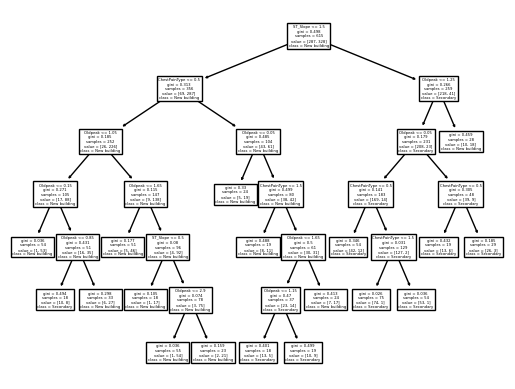

In [55]:
plot_tree(decision_tree=best_model_f, feature_names=X_train_filtered.columns, class_names=['Secondary','New building'])

In [56]:
from sklearn.tree import export_graphviz

export_graphviz(
    best_model,
    feature_names=X_train.columns,
    class_names=['Secondary','New building'],
    out_file = 'small_tree.dot',
    filled = True
)

In [58]:
!dot -Tpng ./small_tree.dot -o ./small_tree.png

### 7.2 Сравнить лучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier на тестовой выборке. Привести значения метрик.

In [54]:
print('-----------DECISION TREE-----------')
print(f'Accuracy:\t{accuracy_score(y_test, best_model.predict(X_test))}')
print(f'Precision:\t{precision_score(y_test, best_model.predict(X_test))}')
print(f'Recall:\t{recall_score(y_test, best_model.predict(X_test))}')
print(f'F-measure:\t{f1_score(y_test, best_model.predict(X_test))}')
print('-----------RANDOM FOREST-----------')
print(f'Accuracy:\t{accuracy_score(y_test, forest_best_model.predict(X_test))}')
print(f'Precision:\t{precision_score(y_test, forest_best_model.predict(X_test))}')
print(f'Recall:\t{recall_score(y_test, forest_best_model.predict(X_test))}')
print(f'F-measure:\t{f1_score(y_test, forest_best_model.predict(X_test))}')
print('-----------KNN-----------')
print(f'Accuracy:\t{accuracy_score(y_test, knn_best_model.predict(X_test))}')
print(f'Precision:\t{precision_score(y_test, knn_best_model.predict(X_test))}')
print(f'Recall:\t{recall_score(y_test, knn_best_model.predict(X_test))}')
print(f'F-measure:\t{f1_score(y_test, knn_best_model.predict(X_test))}')

-----------DECISION TREE-----------
Accuracy:	0.834983498349835
Precision:	0.8963414634146342
Recall:	0.8166666666666667
F-measure:	0.8546511627906977
-----------RANDOM FOREST-----------
Accuracy:	0.8712871287128713
Precision:	0.9325153374233128
Recall:	0.8444444444444444
F-measure:	0.8862973760932943
-----------KNN-----------
Accuracy:	0.6996699669966997
Precision:	0.7572254335260116
Recall:	0.7277777777777777
F-measure:	0.7422096317280452
